In [34]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import joblib
from tabulate import tabulate

from sklearn.preprocessing import RobustScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [35]:
modelling_df = pd.read_csv('Dataset/output_dataset.csv')

In [36]:
# Convert 'country', 'account_currency', 'Trading_Method' and 'active' to categorical
modelling_df['country'] = modelling_df['country'].astype('category')
modelling_df['account_currency'] = modelling_df['account_currency'].astype('category')
modelling_df['Trading_Method'] = modelling_df['Trading_Method'].astype('category')
modelling_df['active'] = modelling_df['active'].astype('category')

In [37]:
# Remove specified columns and set 'longevity' as the target variable
X = modelling_df.drop(columns=['login', 'Total_Trades', 'active', 'Unique_Symbols_Traded', 'Average_Volume', 'longevity', 'longevity_bin'])
y = modelling_df['longevity']

In [38]:
# List of all numeric columns
all_numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# List of categorical columns
categorical_cols = ['country', 'account_currency', 'Trading_Method']  # Specified based on the dataset information provided earlier

# Columns to exclude from scaling
exclude_scaling = ['Buy_Percentage', 'TP/SL Hit Ratio', 'Reward_Risk_Ratio', 'Ratio_Profitable_Trades']

# Numeric columns to be scaled
numeric_cols_to_scale = [col for col in all_numeric_cols if col not in exclude_scaling]

# Create transformers for numeric and categorical data
numeric_transformer = RobustScaler()
categorical_transformer = OrdinalEncoder()

# Create a column transformer to apply the appropriate transformations to each column
preprocessor = ColumnTransformer(
    transformers=[
        ('num_to_scale', numeric_transformer, numeric_cols_to_scale),
        ('num_no_scale', 'passthrough', exclude_scaling),  # Pass through without scaling
        ('cat', categorical_transformer, categorical_cols)
    ])

# Apply transformations to the features
X_preprocessed = preprocessor.fit_transform(X)

# Get numeric feature names directly for scaled and non-scaled
numeric_feature_names = numeric_cols_to_scale + exclude_scaling

# Combine all feature names
all_feature_names_corrected = numeric_feature_names + categorical_cols

# Creating the complete feature DataFrame with the correct feature names
X_preprocessed_df = pd.DataFrame(X_preprocessed, columns=all_feature_names_corrected)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed_df, y, test_size=0.15, random_state=42)

print(f"Train Set Size: {X_train.shape[0]}")
print(f"Test Set Size: {X_test.shape[0]}")

Train Set Size: 4866
Test Set Size: 859


In [40]:
# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [43]:
from keras import layers
from keras import models

model = models.Sequential([
    layers.Dense(1024, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dropout(0.4),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.05),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.05),
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dropout(0.05),
    layers.Dense(4, activation='relu'),
    layers.Dense(1)
])


In [44]:
# Step 4: Compile Model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])  # MSE loss for regression, MAE metric for evaluation

# Step 5: Train Model
history = model.fit(X_train_scaled, y_train, epochs=10000, batch_size=32, validation_split=0.2)

Epoch 1/10000
122/122 [==============================] - 2s 8ms/step - loss: 5428.2573 - mae: 44.2334 - val_loss: 4199.3530 - val_mae: 39.4167
Epoch 2/10000
122/122 [==============================] - 1s 7ms/step - loss: 4865.3711 - mae: 42.8557 - val_loss: 3953.3550 - val_mae: 43.7329
Epoch 3/10000
122/122 [==============================] - 1s 7ms/step - loss: 4549.9248 - mae: 41.3648 - val_loss: 3919.0256 - val_mae: 34.1500
Epoch 4/10000
122/122 [==============================] - 1s 8ms/step - loss: 4262.3232 - mae: 39.1661 - val_loss: 3485.3755 - val_mae: 36.5235
Epoch 5/10000
122/122 [==============================] - 1s 8ms/step - loss: 4157.0454 - mae: 39.2050 - val_loss: 3522.9246 - val_mae: 36.4567
Epoch 6/10000
122/122 [==============================] - 1s 8ms/step - loss: 4224.5288 - mae: 39.0225 - val_loss: 3532.1580 - val_mae: 36.8212
Epoch 7/10000
122/122 [==============================] - 1s 8ms/step - loss: 3966.1172 - mae: 38.0896 - val_loss: 3485.2495 - val_mae: 33.9220

KeyboardInterrupt: 

27/27 [==============================] - 0s 2ms/step - loss: 4632.5830 - mae: 38.4491
Mean Squared Error: 4632.5830078125
Mean Absolute Error: 38.449073791503906
27/27 [==============================] - 0s 2ms/step


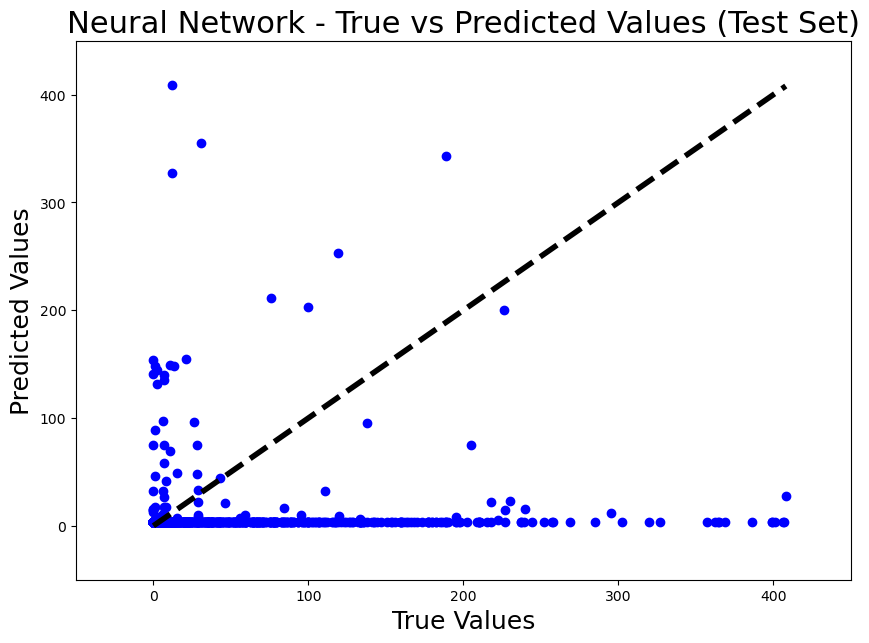

In [45]:
# Step 6: Evaluate Model
mse, mae = model.evaluate(X_test_scaled, y_test)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

y_test_pred = model.predict(X_test)
# Plotting true vs predicted values for test set
fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(y_test, y_test_pred, color='blue')
ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=4)
ax.set_xlim([-50, 450])
ax.set_ylim([-50, 450])
ax.set_xlabel('True Values', fontsize=18)
ax.set_ylabel('Predicted Values', fontsize=18)
ax.set_title(f'Neural Network - True vs Predicted Values (Test Set)', fontsize=22)

plt.show()